# Introduction to Linear Regression

In linear regression, we seek to determine:

- the linear relationship between two variables $x$ and $y$

- the robustness of the relationship, i.e., how well the variations in $x$ explain the variations in $y.

As we will see, regression is simple, but powerful.


## Regression by Example: ENSO and California Precipitation

I lived in California for a while and California is typically known for it's warm and *dry* climate. But, California can experience substantial rainfall in winter and this is related to the phase of the El-Niño Southern Oscillation (ENSO). When there is an El Niño event (anomalously warm sea surface temperatures in the Eastern tropical Pacific), California typically gets more winter rainfall and vice versa when there is a La Niña event.

So, let's take a look at the relationship between ENSO and California precipitation using 1,100 years of output from a global climate model.

In [1]:
# load packages
import numpy as np
import pickle as pickle
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=16,weight='bold') #set default font size and weight for plots

First, we will load in our ENSO and precipitation data from a global climate model. The ENSO index follows the [NINO3.4 definition](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) and is the November-December-January-February (NDJF) average. You can download the file [here](https://github.com/kls2177/ccia_files/blob/master/NINO34_NDJF_2021.pickle?raw=true).

The precipitation data is averaged over the California region and over the winter months, December-January-February-March. You can download the file [here](https://github.com/kls2177/ccia_files/blob/master/CA_PRECIP_DJFM.pickle?raw=true).

In [2]:
# ENSO Data:
# unpickle NINO34 (units of degC)
with open('NINO34_NDJF_2021.pickle','rb') as fp: #.pickle files are a python file type
    nino34 = pickle.load(fp,encoding='latin1')

In [3]:
#  Precipitation Data:
#  unpickle CA_PRECIP_DJFM (units of mm/day)
with open('CA_PRECIP_DJFM.pickle','rb') as fp: #.pickle files are a python file type
    precip_djfm = pickle.load(fp,encoding='latin1')

Let's check the shape of our data - we should have 1,100 years of data for each variable.

In [4]:
# check shape of data
print(nino34.shape,precip_djfm.shape)

(1100,) (1100,)


Before we do anything, we should take a quick look at our data. Let's plot time series plots of the NINO3.4 Index and our DJFM California precipitation. We want to check that our data looks reasonable, that we don't have any suspicious outliers and that we don't have any missing data.

Text(0.5, 0, 'time')

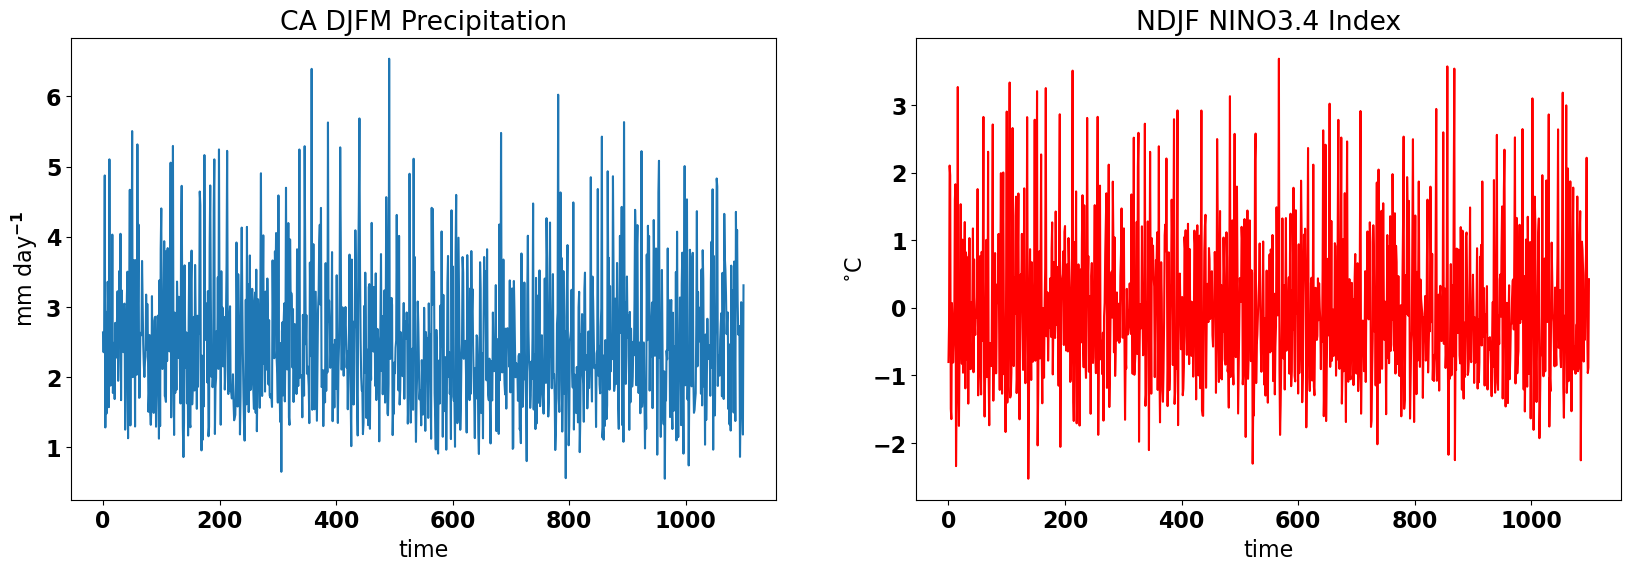

In [5]:
# plot the precip and NINO34 time series
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(precip_djfm)
plt.title("CA DJFM Precipitation")
plt.ylabel("mm day$^{-1}$")
plt.xlabel("time")

plt.subplot(1,2,2)
plt.plot(nino34,color='r')
plt.title("NDJF NINO3.4 Index")
plt.ylabel("$^{\circ}$C")
plt.xlabel("time")

The data looks reasonable, so, let's start our investigation of the relationship between ENSO and wintertime California precipitation.

Let's start by plotting a scatter plot. Which is the predictor and which is the predictand?

Text(0.5, 1.0, 'Scatter Plot: NINO3.4 vs. CA Precip')

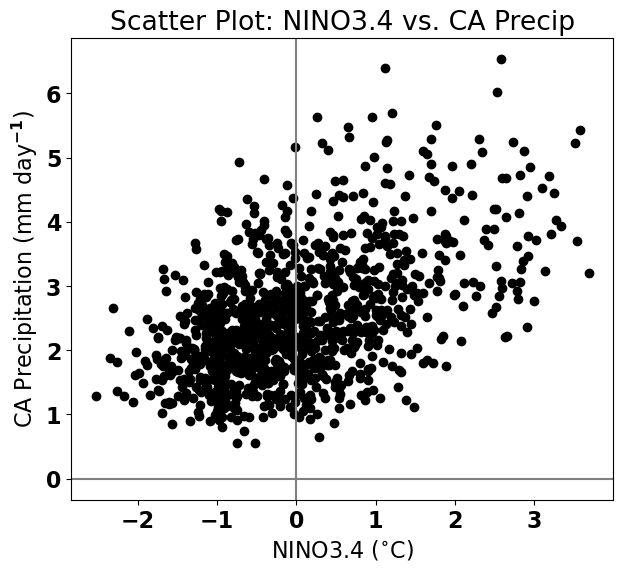

In [6]:
# scatter plot of CA Precip versus NINO34
plt.figure(figsize=(7,6))
plt.axhline(0,color='gray')  # add zero lines for reference
plt.axvline(0,color='gray')  # add zero lines for reference
plt.scatter(nino34,precip_djfm,color='k')

# labels, legends, etc.
plt.xlabel('NINO3.4 ($^{\circ}$C)')
plt.ylabel('CA Precipitation (mm day$^{-1}$)')
plt.title('Scatter Plot: NINO3.4 vs. CA Precip')

Based on this scatter plot, it looks like California precipitation increases as the NINO3.4 index increases. This suggests that we should be able to construct a linear relationship between these two variables.

### Aside: Data Visualization

Before, we get into the mathematics of linear regression, let's take a brief detour into **data visualization**. Effective data visualization is not trivial and it is an extremely important part of science communication. Details in diagrams and plots are often simple but can help to convey meaning. For example, we can make our plot more meaningful by highlighting the El Niño and La Niña events.

SST anomalies in the NINO3.4 region are considered El Niño events if they exceed 0.5$^\circ$C and La Niña events if they fall below -0.5$^\circ$C. Small magnitude SST anomalies are simply considered neutral ENSO years. Let's use load a file that identifies these events ([here](https://github.com/kls2177/ccia_files/blob/master/ENSO_NDJF_years_rev.pickle?raw=true)).

In [7]:
# unpickle data indicating strong El Niño/La Niña years
with open('ENSO_NDJF_years_rev.pickle','rb') as fp:   #another .pickle file
    elnino_yrs,lanina_yrs = pickle.load(fp,encoding='latin1')

# create groups of strong El Niño/La Niña years
ElNinoyrs = nino34[np.squeeze(elnino_yrs)]
LaNinayrs = nino34[np.squeeze(lanina_yrs)]

ElNinoP = precip_djfm[np.squeeze(elnino_yrs)]
LaNinaP = precip_djfm[np.squeeze(lanina_yrs)]

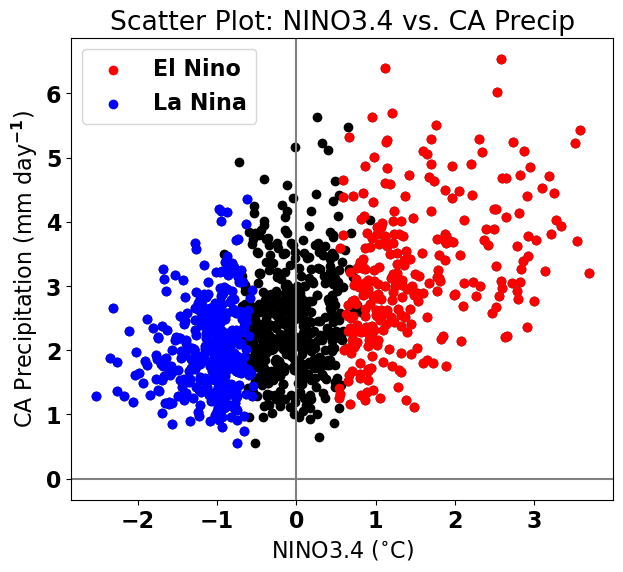

In [8]:
# re-plot: detailed version
plt.figure(figsize=(7,6))
plt.axhline(0,color='gray')
plt.axvline(0,color='gray')
plt.scatter(nino34,precip_djfm,color='k')
plt.scatter(ElNinoyrs,ElNinoP,color='r',label='El Nino')
plt.scatter(LaNinayrs,LaNinaP,color='b',label='La Nina')

# labels, legends, etc.
plt.xlabel('NINO3.4 ($^{\circ}$C)')
plt.ylabel('CA Precipitation (mm day$^{-1}$)')
plt.title('Scatter Plot: NINO3.4 vs. CA Precip')
plt.legend(loc='upper left')

Looks nice!

## Ordinary Least-Squares (OLS) Linear Regression

How do we find the slope and y-intercept of a line that best fits the relationship between the NINO3.4 index and California precipitation?

Let’s assume $x(t)$ and $y(t)$ are time series of size $N$ (i.e., the data is sampled at $N$ time steps). The goal of linear regression is to be able to reconstruct or predict $y(t)$ using $x(t)$. Thus, we denote $x(t)$ as the **predictor** and $y(t)$ as the **predictand**. Sometimes $x(t)$ is termed the **independent variable** and $y(t)$ the **dependent variable**.

To begin, we have to define what **“best-fit"** means. We will use the conventional OLS definition which defines best-fit as the line that *reduces the sum of the squared errors of $y$*.

### Terminology

We will define the equation for the best-fit line as,

$$
\hat{y(t)} = a_1x(t) + a_0
$$

where

- $\hat{y(t)}$ denotes the estimate of $y(t)$ based on its linear relationship with $x(t)$
- $a_1$ denotes the slope, aka the **regression coefficient**
- $a_0$ denotes the y-intercept

[Figure 11](OLS_schematic) shows what the best-fit line, $\hat{y(t)}$, between $y(t)$ and $x(t)$ looks like for some made-up data. $a_1$ is the slope of this line and tells us the magnitude of the best-fit relationship between $y(t)$ and $x(t)$. The y-intercept, $a_0$ tells us the best-fit value for $\hat{y(t)}$ when $x(t)$ is zero.

```{figure} OLS_schematic.png
---
scale: 100%
name: OLS_schematic
---
Scatter plot of $y(t)$ versus $x(t)$ (blue dots) and the OLS best-fit line (red line). The distances in the y-direction from a blue dots to the red line are defined as the residuals.
```

The **residuals** are differences between the fitted values, $\hat{y_i(t)}$ and the actual values, $y_i(t)$ as illustrated in [Figure 11](OLS_schematic). The residuals describe the error in the linear fit - the smaller the residuals, the better the fit.

### Sum of Squared Errors

As noted above, the best-fit line is the line that minimized the sum of squared errors, $Q$. But, what is $Q$? $Q$ is sum of the squared residuals (aka the errors),

$$
\begin{align}
Q &= \sum\limits_{i=1}^N(\hat{y_i(t)} - y_i(t))^2\\
&= \sum\limits_{i=1}^N(a_1x(t) + a_0 - y_i(t))^2\\
\end{align}
$$

where the subscript $i$ denotes, e.g., the time step for time series data. 

The errors are *squared* so that:

- the errors are positive definite (so positive and negative errors don’t cancel out). Note that the square causes larger errors to be more heavily weighted.
- the minimization of Q (the derivative of Q (see below)) is a linear problem

### The Best-Fit Line: Minimizing *Q*

We are now ready to find $a_0$ and $a_1$ that minimize $Q$. To do this, we take the derivative of $Q$ with respect to $a_0$ and $a_1$, separately and then solve for these coefficients. This involves a bit of calculus (painless, I promise!).

Let's start by minimizing $Q$ with respect to $a_0$.

$$
\begin{align}
\frac{dQ}{da_0} &= 0\\
0 &= 2\sum\limits_{i=1}^N(a_1x(t) + a_0 - y_i(t))\\
0 &= a_1\sum\limits_{i=1}^Nx(t) + a_0N - \sum\limits_{i=1}^Ny_i(t)\\
\end{align}
$$

Now, let's minimize $Q$ with respect to $a_1$.

$$
\begin{align}
\frac{dQ}{da_1} &= 0\\
0 &= 2\sum\limits_{i=1}^N(a_1x(t) + a_0 - y_i(t))x_i(t)\\
0 &= a_1\sum\limits_{i=1}^Nx(t)^2 + a_0x_i(t) - \sum\limits_{i=1}^Nx_i(t)y_i(t)\\
\end{align}
$$

For both of the above equations, we can do the sums, divide through by $N$ and move the $y_i(t)$ terms to the left hand side to get the following two equations:

$$
\begin{align}
\overline{y} &= a_1\overline{x} + a_0\\
\overline{xy} &= a_1\overline{x^2} + a_0\overline{x}
\end{align}
$$

where overbars denote the mean.

Two equations, two unknowns: so we can solve for $a_0$ and $a_1$! Yay!

To solve this, it helps to use the following expressions:

$$
\begin{align}
\overline{xy} &= \overline{x}\overline{y} + \overline{x^{\prime}y^{\prime}}\\
\overline{x^2} &= \overline{x}^2 + \overline{{x^\prime}^2}
\end{align}
$$

Plugging these in, we get

$$
\begin{align}
a_1 &= \frac{\overline{x^{\prime}y^{\prime}}}{\overline{{x^\prime}^2}}\\
a_0 &= \overline{y} - a_1\overline{x}
\end{align}
$$

```{note} 
$$
\begin{align}
a_1 &= \frac{\overline{x^{\prime}y^{\prime}}}{\overline{{x^\prime}^2}}
\end{align}
$$

$a_1$ is:

- the slope of the best-fit line
- the regression coefficient
- equal to the **covariance of $x$ and $y$** divided by the **variance of $x$**

---------------------------------------------------------------------------------------------------------------

$$
\begin{align}
a_0 &= \overline{y} - a_1\overline{x}
\end{align}
$$

$a_0$ is:

- the y-intercept. Note that if the means of the time series are 0 (which is the case if $x$ and $y$ are anomalies), then $a_0$ = 0.
```

Let's revisit our ENSO and California precipitation example and calculate the best-fit line using OLS linear regression.

## Example Revisited

We will learn two ways to calculate the best-fit line using python. The first way is using the numpy function called ["polyfit"](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html). This function can be used to fit a polynomial of degree, $n$, but we will simply use it to fit a polynomial of degree 1 (which is a straight line).

In [9]:
# calculate best-fit line

# np.polyfit(predictor, predictand, degree)
a = np.polyfit(nino34,precip_djfm,1) #polynomial fit, degree = 1 means a linear fit

The output of polyfit is an array with two elements, the slope and the y-intercept.

In [10]:
print(a.shape)

(2,)


Let's take a look at what we get.

In [11]:
print("The slope is", np.round(a[0],2), " and the y-intercept is", np.round(a[1],2))

The slope is 0.44  and the y-intercept is 2.5


In order to plot our best-fit line on our scatter plot, we need the $\hat{y(t)}$ values. To obtain these values, we can either calculate them directly using the equation for $\hat{y(t)}$ or we can use the numpy function, [`polyval`](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html#numpy.polyval).

In [12]:
# construct the linear fit

# method 1: y_hat = ao + a1*x
y_hat = a[1] + a[0]*nino34

# method 2: np.polyval()
y_hat = np.polyval(a,nino34)

Now, we can add the best-fit line to our scatter plot.

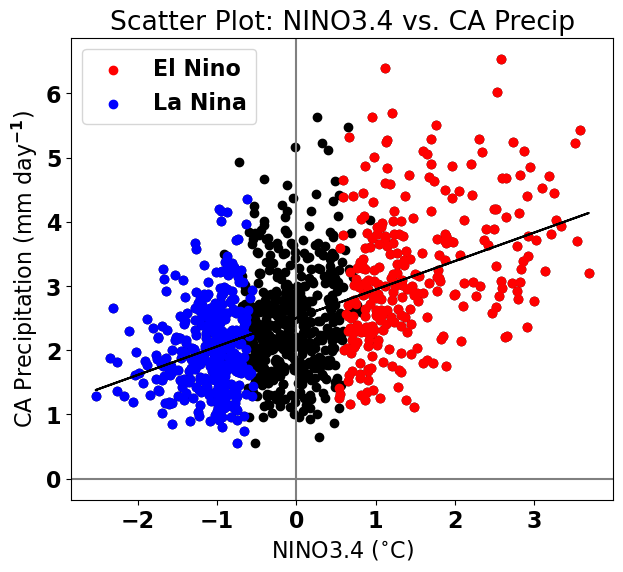

In [13]:
#add linear fits to the plot above
plt.figure(figsize=(7,6))
plt.axhline(0,color='gray')
plt.axvline(0,color='gray')
plt.scatter(nino34,precip_djfm,color='k')
plt.scatter(ElNinoyrs,ElNinoP,color='r',label='El Nino')
plt.scatter(LaNinayrs,LaNinaP,color='b',label='La Nina')

# add best-fit line
plt.plot(nino34,y_hat,'k')

# labels, legends, etc.
plt.xlabel('NINO3.4 ($^{\circ}$C)')
plt.ylabel('CA Precipitation (mm day$^{-1}$)')
plt.title('Scatter Plot: NINO3.4 vs. CA Precip')
plt.legend(loc='upper left')